# Figure 8: Probability first outbreak observed in each neighbourhood

## Abby Barlow, University of Bath
## Ben Adams, University of Bath

### Importing required libraries

In [1]:
%matplotlib inline
import time
import numpy as np
import pylab as plt
import random
import multiprocessing as mp
from scipy.optimize import fsolve

### Importing required scripts

In [2]:
import importlib
import Gillespie_household_model_6neigh
import Gillespie_household_6neigh_first   # only records first neighbourhood outbreak
import R_star_construct

importlib.reload(Gillespie_household_model_6neigh)
importlib.reload(Gillespie_household_6neigh_first)
importlib.reload(R_star_construct)

do_Gillespie = Gillespie_household_model_6neigh.do_Gillespie
do_Gillespie_first = Gillespie_household_6neigh_first.do_Gillespie
RstarAnal = R_star_construct.RstarAnal

### Parameters

In [3]:
h1,h2,h3,h4,h5,h6 = 2520,2520,1260,1260,840,840      # no. of households in each neighbourhood
n1,n2,n3,n4,n5,n6 = 2,2,4,4,6,6                      # size of households for each neighbourhood
N_neigh = 6

gamma = 0.2                                                 # recovery rate from infection
days = 100                                                  # no. of days in simulation
tStart, tEnd = 0, days                                      # start time and end time (days) of simulation

time_points = np.linspace(tStart, tEnd, days+1)  # time points for Gillespie output, daily
chains = 50000

H = np.array([h1,h2,h3,h4,h5,h6])
N = np.array([n1,n2,n3,n4,n5,n6])

In [4]:
nu = 3      # good range 1 to 6 (2 to 4)
beta = fsolve(RstarAnal,0.5,(gamma,nu))[0]
alpha = beta/nu

alpha=round(alpha,2)
beta=round(beta,2)
alpha,beta

(0.27, 0.8)

### Run sims for 6 neighbourhoods

In [5]:
obs_outbreak4 = 7*np.ones(chains)    # initially populate arrays with 7s so not confuse with zeros from
first_inf = 7*np.ones(chains)        # neighbourhood zero

alpha_vec = np.zeros(chains, dtype=object) # intialising array to store each set of alpha values
                                           # we simulate proportion of contacts reserved for ones own 
for chain in range(chains):                # neighbourhood each run  

    p_weak = np.random.uniform(0.4,0.5,1)[0] # realisation of r for weakly connected neighbourhoods
    p_strong = np.random.uniform(0,0.1,1)[0] # realisation of r for strongly connected neighbourhoods

    p_reserve = np.array([p_strong,p_weak,p_strong,p_weak,p_strong,p_weak])
    rho = np.zeros((N_neigh,N_neigh))

    for i in range(N_neigh):   # using the r values to calculate the rho values
        for j in range(N_neigh):
            rho[i,j] = (1-p_reserve[i])*(1-p_reserve[j])*H[j]*N[j]/(np.sum((1-p_reserve)*H*N))
        rho[i,i] = p_reserve[i] + (1-p_reserve[i])*(1-p_reserve[i])*H[i]*N[i]/(np.sum((1-p_reserve)*H*N))
    alpha_vec[chain] = alpha*rho   # saving all 'alpha' vectors for each simulation run

t = time.process_time()          # timing how long to run
pool = mp.Pool(mp.cpu_count())   # start paralellisation

Infs = np.zeros(N_neigh)
Infs[0] = 1                   # not actually needed just left in code atm

params_dict = {'beta': [beta,beta,beta,beta,beta,beta], 
               #'alpha': alpha, # this is different for each run now
               'gamma':gamma,
               'n': N, 
               'h': H,
               'inf0': Infs,
               'tStart':tStart,
               'tEnd':tEnd,
               'time_points':time_points
              }
# we create a seperate dictionary containing the alpha values for each run and then merge the 2 together    
neigh6_results2 = pool.map(do_Gillespie_first, [{**params_dict,**{'alpha': alpha_vec[i]}} for i in range(chains)])
   
pool.close()     # stop parallelisation

elapsed_time = time.process_time() - t    # time took to run
print("elapsed time: ", elapsed_time)

elapsed time:  0.734375


### Unpacking results and finding first observed neighbourhood outbreak

In [6]:
obs_outbreak4 = 7*np.ones(chains)    # initialise array for first neighbourhood observed outbreak
first_inf = 7*np.ones(chains)        # initialise array for first neighbourhood infection

for i in range(chains):                            # unpacking results
    if neigh6_results2[i][0] != 7:
        obs_outbreak4[i] = neigh6_results2[i][0]
        first_inf[i] = neigh6_results2[i][1]
    
obs_outbreak4 = [out for out in obs_outbreak4 if out != 7]  # removing results where no outbreak occurred
first_inf = [outs for outs in first_inf if outs != 7]

In [7]:
# save results so don't have to keep rerunning
np.savetxt('obs_outbreak4.csv', obs_outbreak4, delimiter=',')
np.savetxt('first_inf.csv', first_inf, delimiter=',')

In [8]:
## calculate the probability an outbreak first observed in each neighbourhood
prob_neigh2 = np.bincount(obs_outbreak4,minlength=6)/len(obs_outbreak4)

### Producing figure

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


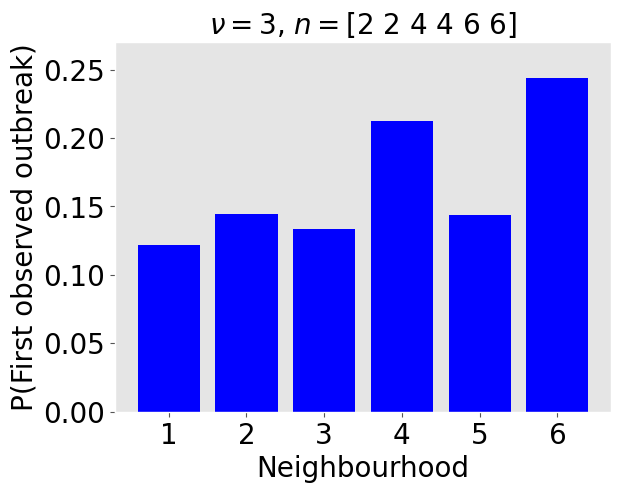

In [9]:
plt.style.use('ggplot')

x = ['1', '2', '3', '4', '5', '6']

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, prob_neigh2, color='blue')
plt.xlabel("Neighbourhood", fontsize=20, color='black')
plt.ylabel('P(First observed outbreak)', fontsize=20, color='black')
plt.grid(False)
plt.xticks(x_pos, x, fontsize=20, color='black')
plt.yticks(fontsize=20, color='black')
plt.ylim(0,0.27)
plt.title(r'$\nu=${}, $n=${}'.format(nu,N), fontsize=20)
#plt.savefig('prob_obs_out_range.pdf', bbox_inches='tight')

plt.show()

### Comparing for different $\nu$

In [10]:
nu_results = np.zeros((3,N_neigh))   # initialise array to store results for each nu value
nu_var = [1,3,5]                     # list of nu values

t = time.process_time()       # recording how long runs for

for n in range(len(nu_var)):   # looping over different nu values
    nu = nu_var[n]
    beta = fsolve(RstarAnal,0.5,(gamma,nu))[0]   # finding beta value for specified nu
    alpha = beta/nu                              # finding alpha
    alpha = round(alpha,2)   # rounding to 2 dp.
    beta = round(beta,2)
    
    obs_outbreak = np.zeros(chains)    # initialising array to unpack results into
    
    alpha_vec = np.zeros(chains, dtype=object) # intialising array to store each set of alpha values
                                           # we simulate proportion of contacts reserved for ones own 
    for chain in range(chains):                # neighbourhood each run  

        p_weak = np.random.uniform(0.4,0.5,1)[0] # realisation of r for weakly connected neighbourhoods
        p_strong = np.random.uniform(0,0.1,1)[0] # realisation of r for strongly connected neighbourhoods

        p_reserve = np.array([p_strong,p_weak,p_strong,p_weak,p_strong,p_weak])
        rho = np.zeros((N_neigh,N_neigh))

        for i in range(N_neigh):   # using the r values to calculate the rho values
            for j in range(N_neigh):
                rho[i,j] = (1-p_reserve[i])*(1-p_reserve[j])*H[j]*N[j]/(np.sum((1-p_reserve)*H*N))
            rho[i,i] = p_reserve[i] + (1-p_reserve[i])*(1-p_reserve[i])*H[i]*N[i]/(np.sum((1-p_reserve)*H*N))
        alpha_vec[chain] = alpha*rho   # saving all 'alpha' vectors for each simulation run


    pool = mp.Pool(mp.cpu_count())  # start paralellisation

    Infs = np.zeros(N_neigh)
    Infs[0] = 1                   # not actually needed just left in code atm

    params_dict = {'beta': [beta,beta,beta,beta,beta,beta], 
               'gamma':gamma,
               'n': N, 
               'h': H,
               'inf0': Infs,
               'tStart':tStart,
               'tEnd':tEnd,
               'time_points':time_points
              }
    # we create a seperate dictionary containing the alpha values for each run and then merge the 2 together    
    neigh6_results0 = pool.map(do_Gillespie_first, [{**params_dict,**{'alpha': alpha_vec[i]}} for i in range(chains)])

    pool.close()    # end paralellisation

    for i in range(chains):
        obs_outbreak[i] = neigh6_results0[i][0]
    obs_outbreak = [out for out in obs_outbreak if out != 7]
    # record probability of outbreak first being observed in each neighbourhood for each nu value
    nu_results[n,:] = np.bincount(obs_outbreak,minlength=6)/len(obs_outbreak)

elapsed_time = time.process_time() - t     # record time took to run
print("elapsed time: ", elapsed_time)

elapsed time:  69.484375


In [11]:
# save results so don't have to keep rerunning
np.savetxt('nu_results.csv', nu_results, delimiter=',')

### Producing figure

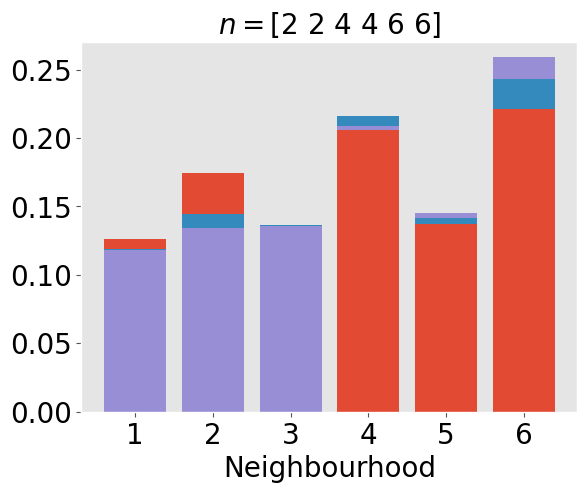

In [12]:
heights_a = nu_results[0,:]  # nu=1  red
heights_b = nu_results[1,:]  # nu=3  blue
heights_c = nu_results[2,:]  # nu=5  purple

position = np.arange(N_neigh)
colors = ['C0','C1','C2']

plt.figure()

# want coloured bars to be overlapping so can compare
for x,ha,hb,hc in zip(position, heights_a, heights_b, heights_c):
    for i, (h, c) in enumerate(sorted(zip([ha,hb,hc], colors))):
        plt.style.use('ggplot')
        plt.bar(x, h, color=c, zorder=-i,alpha=1)
plt.grid(False)
plt.xlabel('Neighbourhood', color='black', fontsize=20)
#plt.ylabel('P(First observed outbreak)', color='black', fontsize=20)
plt.title(r'$n=${}'.format(N,p_reserve), color='black', fontsize=20)
plt.xticks([0,1,2,3,4,5], labels = [1,2,3,4,5,6], color='black', fontsize=20)
plt.yticks(color='black', fontsize=20)
plt.ylim(0,0.27)
#plt.legend()
plt.savefig('prob_obs_out_range_nus.pdf', bbox_inches='tight')
plt.show()